In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [4]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


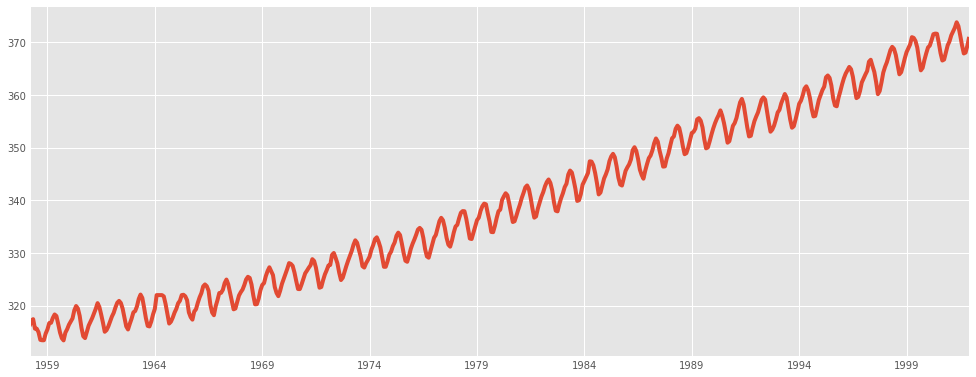

In [5]:
y.plot(figsize=(15, 6))
plt.show()

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624032982
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727640927
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878579768335
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897806985
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913075614
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754229354
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327822148
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067014495
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716841512
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1085.52473663032
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4315035121449
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.595789361149
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.091298822604
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919409
ARIMA

In [8]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.811      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


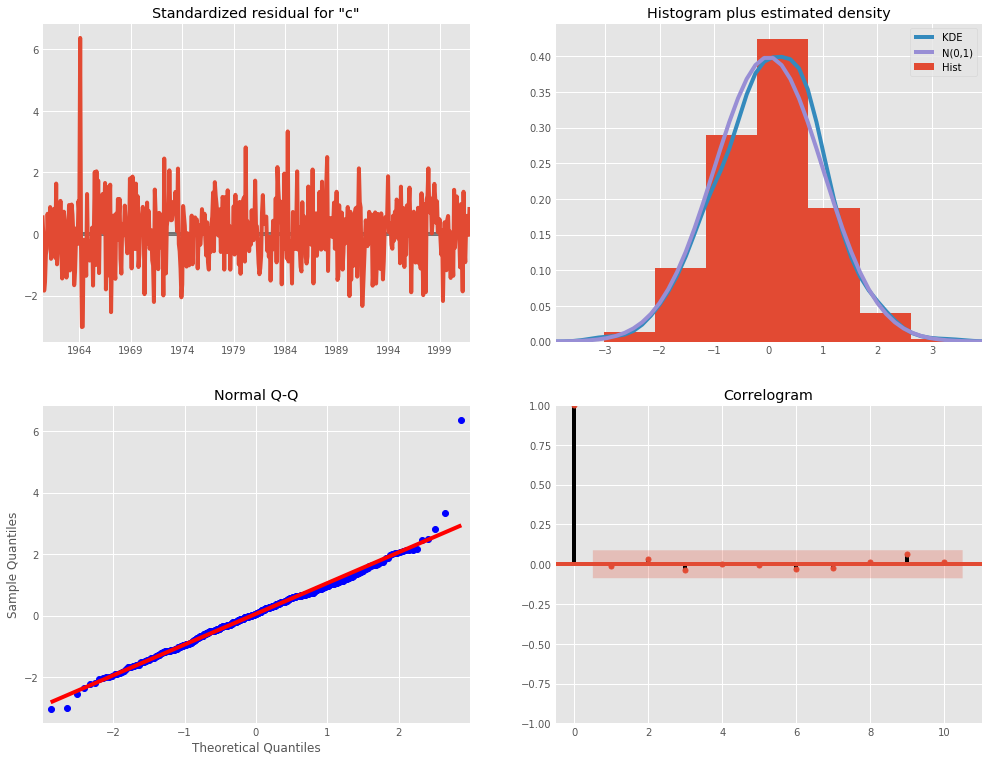

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [10]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

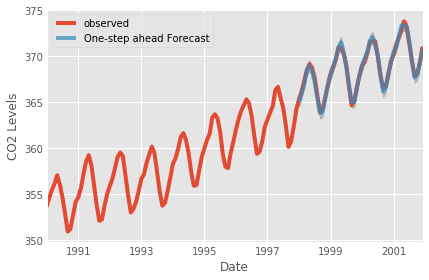

In [11]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [14]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [13]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

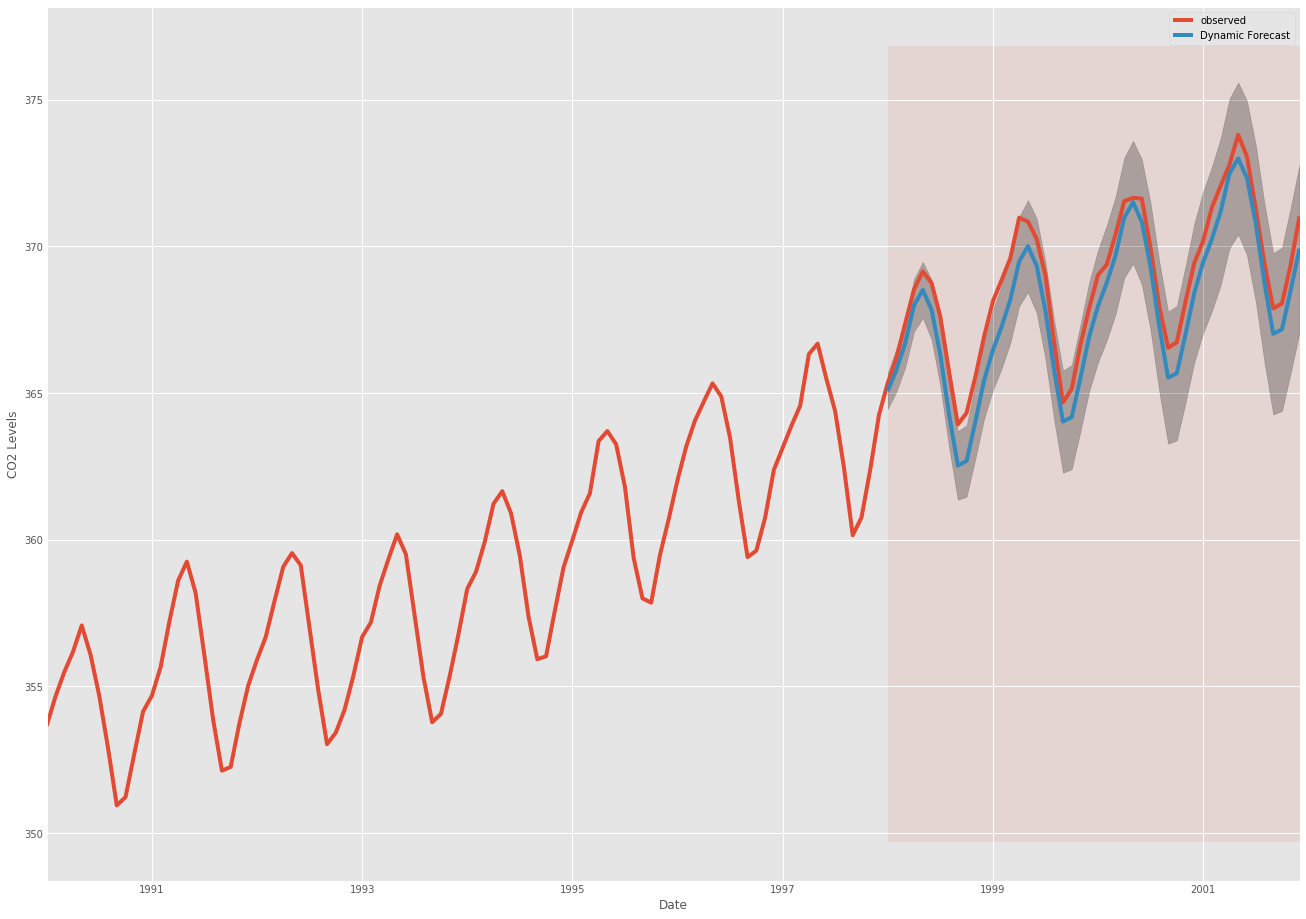

In [15]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [16]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [17]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

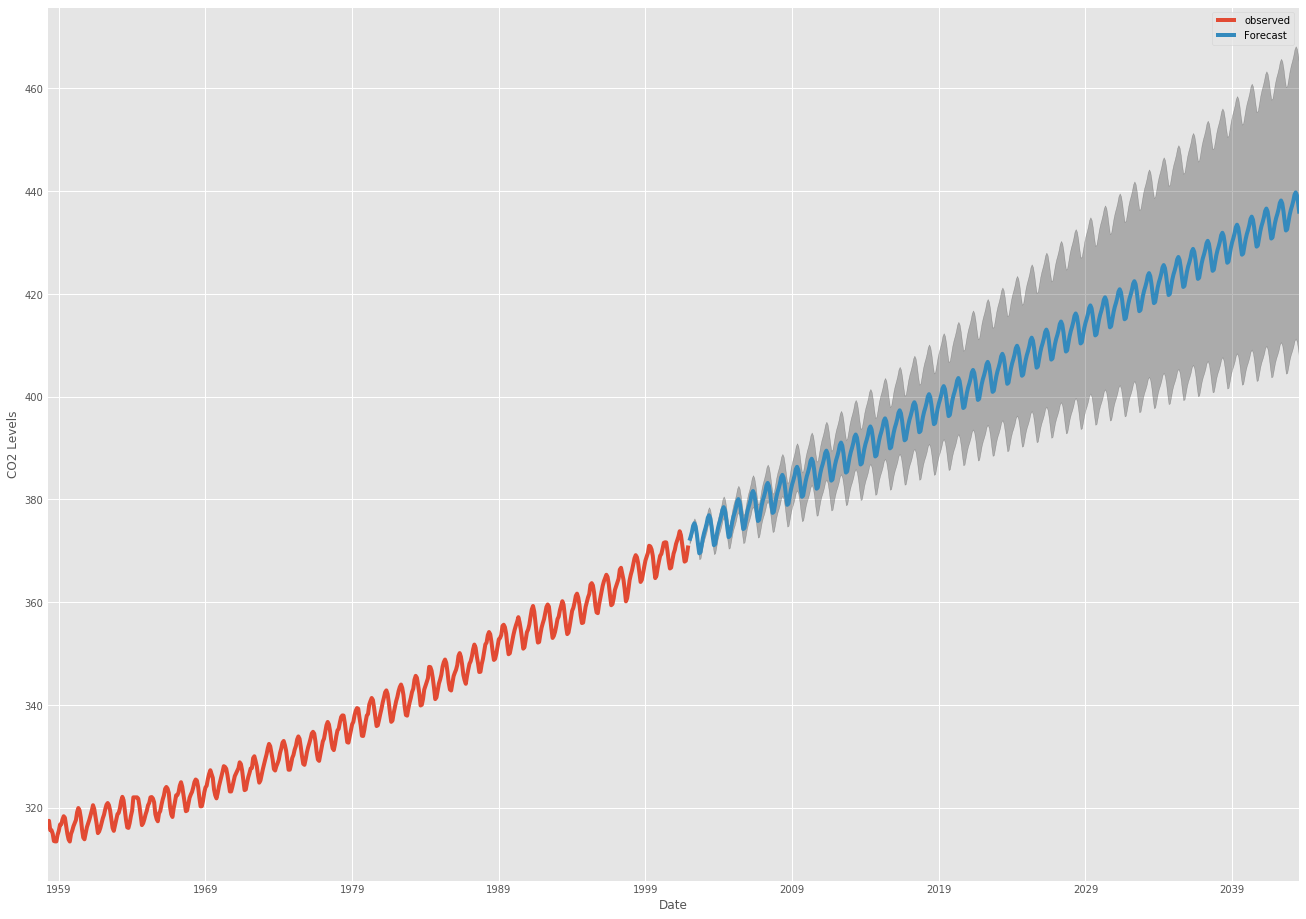

In [18]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()